# Data Science PI7, Part 1

### 1. SQL Database Analysis

To assess the available values in our database ("cycling_big.db"), we will have to explore our database.
We will import the necessary modules and then make a query to our database by calling //the names of the tables and their column values//

Note that these operations are better handled by data handling and manipulation modules, like Pandas, which will be used later on.

In [1]:
import sqlite3 as lite
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import ast

In [2]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

print("The following tables are present in our database")
for row in tables:
    print(row)

# We will be closing the database connection at the end of each code cell.
# By doing this we can make sure that queries dont interact with unwanted code cells.
conn.close()

The following tables are present in our database
('riders',)
('race_results',)
('sqlite_sequence',)


Note that the tables 'riders' and 'race_results' are present in the database. 
With this information, a query can be made to print out the first ten rows from our tables.

In [3]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

conn = lite.connect('cycling_big.db')

# Execute a query to select all entries and put the labels in an arrary of description values

cur.execute('SELECT * FROM race_results')

columns_race = [description[0] for description in cur.description]

print("Columns for race_results:", columns_race)

cur.execute('SELECT * FROM riders')

columns_rider = [description[0] for description in cur.description]

print("Columns for riders:", columns_rider)

conn.close()

Columns for race_results: ['id', 'Rnk', 'GC', 'Timelag', 'BiB', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Time', 'Circuit', 'Race_Name', 'Stage_Name', 'Date', 'Stage_Type', 'Start', 'Finish', 'Race_ID', 'Stage_Number', 'Length', 'Category', 'Race_url', 'Stage_url', 'rider_id']
Columns for riders: ['rider_id', 'fullname', 'team', 'birthdate', 'country', 'height', 'weight', 'rider_url', 'pps', 'rdr']


#### Evaluating empty values quickly

Now let's quickly identify the amount of empty cells for race results. 
This will not give a full scope of missing or incorrect data, but this will offer us a quick overview of the columns that are missing entries.
Ofcourse, entry values like 'Date' can be expected to be unstandardized, or a value can be entered as 'null', but will still count as a value, so using SQL queries will not be the most accurate to determine missing or unstandardized data.

In [4]:
conn = lite.connect('cycling_big.db')
cur = conn.cursor()

cur.execute("PRAGMA table_info(race_results);") # Quick and dirty PRAGMA statement to return info on a column
columns = cur.fetchall()

# Building an SQL query to loop through all the columns to count nulls
null_count = "SELECT "

# Add each column's NULL count
null_count += ", ".join([f"SUM(CASE WHEN {column[1]} IS NULL THEN 1 ELSE 0 END) AS {column[1]}_null" for column in columns])

null_count += " FROM race_results;"

# Execute the query
cur.execute(null_count)

# Fetch the result
null_counts = cur.fetchone()

print("\nMissing Values Count for Each Column:")
print("-" * 50)
print(f"{'Column Name':<30} {'Missing Values'}")
print("-" * 50)

# Looping through the columns and applying formatting
for i, column in enumerate(columns):
    column_name = column[1]  # Column name is the second element in the tuple
    missing_values = null_counts[i]
    print(f"{column_name:<30} {missing_values:>15}")

print("-" * 50)

conn.close()


Missing Values Count for Each Column:
--------------------------------------------------
Column Name                    Missing Values
--------------------------------------------------
id                                           0
Rnk                                          0
GC                                       30420
Timelag                                  30420
BiB                                          0
Rider                                        0
Age                                          0
Team                                        29
UCI                                     214074
Pnt                                     194158
Time                                         0
Circuit                                      0
Race_Name                                    0
Stage_Name                               25241
Date                                         0
Stage_Type                                   0
Start                                        0
Finish        

### 2. Database Extraction and Deserialization

Below is a code sample for extracting data from a SQLite database. Using the built in 'sqlite' module for python, we can open a connection by calling the 'connect()' function that points to a "*.db" file. The returned connection object, named 'conn', represents the connection to the on-disk database. This essentially creates an interface for python to interact with the SQLite database. Using the 'Pandas' module, we can put this deserialized data from the database into a dataframe. A dataframe preserves the rows and columns from the relevant database. By using this data frame, the data from the database can be used for data handling, manipulation and further analysis.

In [5]:
# As shown in the above cells, a connection to the ".db" file can be established by 
conn = lite.connect("cycling_big.db")

table_names = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn) # Sqlite master is a system table that holds information like table names 
df = pd.read_sql(f"SELECT * FROM {table_names['name'][0]}", conn) # Access the first tables name from the table_names dataframe

conn.close()

df.head()

,rider_id,fullname,team,birthdate,country,height,weight,rider_url,pps,rdr
0,5e4c220d0657face20e49719b725a001,BARDET Romain,Team DSM,1990-11-09,France,1.84,65.0,https://www.procyclingstats.com/rider/romain-b...,"{'One day races': '2620', 'GC': '5138', 'Time ...","{'PCS Ranking': '43', 'UCI World Ranking': '52..."
1,995d110d3b2e05830409874b401a3218,DUMOULIN Samuel,noteam,1980-08-20,France,1.59,57.0,https://www.procyclingstats.com/rider/samuel-d...,"{'One day races': '3681', 'GC': '1277', 'Time ...",{'Specials | All Time Ranking': '365'}
2,21b52056733e39f06885dfb9d18bc77a,GALLOPIN Tony,AG2R Citroën Team,1988-05-24,France,1.80,69.0,https://www.procyclingstats.com/rider/tony-gal...,"{'One day races': '2864', 'GC': '2268', 'Time ...","{'PCS Ranking': '511', 'UCI World Ranking': '9..."
3,3fe13c77eb187357fa58c810a7aa7083,NAESEN Oliver,AG2R Citroën Team,1990-09-16,Belgium,1.84,72.0,https://www.procyclingstats.com/rider/oliver-n...,"{'One day races': '3619', 'GC': '1157', 'Time ...","{'PCS Ranking': '203', 'UCI World Ranking': '1..."
4,ae00cdf6b464b193c1a34e08fe1eded7,FRANK Mathias,noteam,1986-12-09,Switzerland,1.76,64.0,https://www.procyclingstats.com/rider/mathias-...,"{'One day races': '702', 'GC': '2803', 'Time t...","{'PCS Ranking': '755', 'UCI World Ranking': '9..."


### 3. Exploratory Data Analysis

Exploratory analysis can be used to identify extreme cases and determine wether they should be eliminated.

- Boxplots will be made to identify outliers in the following features: ///. This is also useful for unsupervised learning, since a boxplot can display relations between a numerical and a categorical value.
- Scatterplots will be made to identify relations between the following continuous variables: age vs ranking and weight vs race position.
- A histogram will be made to analyze the distribution of numeric data for the distribution of points among cyclists.
- Heatmap to analyse correlation between variables

In [6]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

# Combine the tables so we can use variables from the two tables for analysis
# We attach rider information to races table, so that every entry in the races will have additional information on the rider
# rider_id is the key connecting the tables
df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'))

conn.close()
df.head(3)

,id,Rnk,GC,Timelag,BiB,Rider,Age,Team,UCI,Pnt,...,Stage_url,fullname,team,birthdate,country,height,weight,rider_url,pps,rdr
rider_id,,,,,,,,,,,,,,,,,,,,,
659ed585810c65fe22255a5e4a9b7838,1,1,1.0,+0:00,0,GREIPEL André,29,Lotto Belisol Team,6.0,50.0,...,/stage-1/result/result,GREIPEL André,Israel Start-Up Nation,1982-07-16,Germany,1.84,80.0,https://www.procyclingstats.com/rider/andre-gr...,"{'One day races': '4650', 'GC': '1921', 'Time ...","{'PCS Ranking': '133', 'UCI World Ranking': '2..."
None,2,2,2.0,+0:04,0,PETACCHI Alessandro,38,Lampre - ISD,4.0,30.0,...,/stage-1/result/result,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
None,3,3,4.0,+0:06,0,HUTAROVICH Yauheni,28,FDJ - BigMat,2.0,18.0,...,/stage-1/result/result,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 225918 entries, 659ed585810c65fe22255a5e4a9b7838 to 331c623e3f33d0a010a7ab49c5cac0c7
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            225918 non-null  int64  
 1   Rnk           225918 non-null  object 
 2   GC            195498 non-null  float64
 3   Timelag       195498 non-null  object 
 4   BiB           225918 non-null  object 
 5   Rider         225918 non-null  object 
 6   Age           225918 non-null  int64  
 7   Team          225889 non-null  object 
 8   UCI           11844 non-null   float64
 9   Pnt           31760 non-null   float64
 10  Time          225918 non-null  object 
 11  Circuit       225918 non-null  int64  
 12  Race_Name     225918 non-null  object 
 13  Stage_Name    200677 non-null  object 
 14  Date          225918 non-null  object 
 15  Stage_Type    225918 non-null  object 
 16  Start         225918 non-null  object 
 

Text(0, 0.5, 'Age')

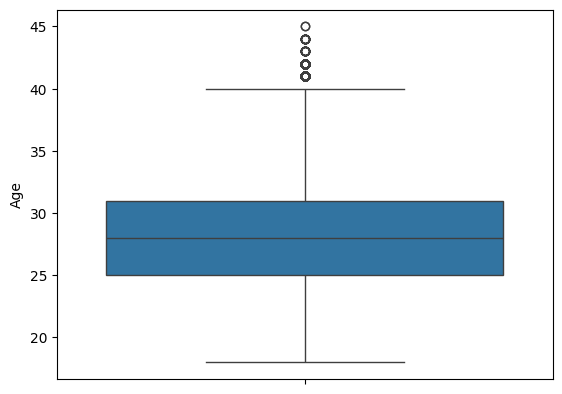

In [8]:
sns.boxplot(data=df['Age'])
plt.xlabel("")
plt.ylabel("Age")

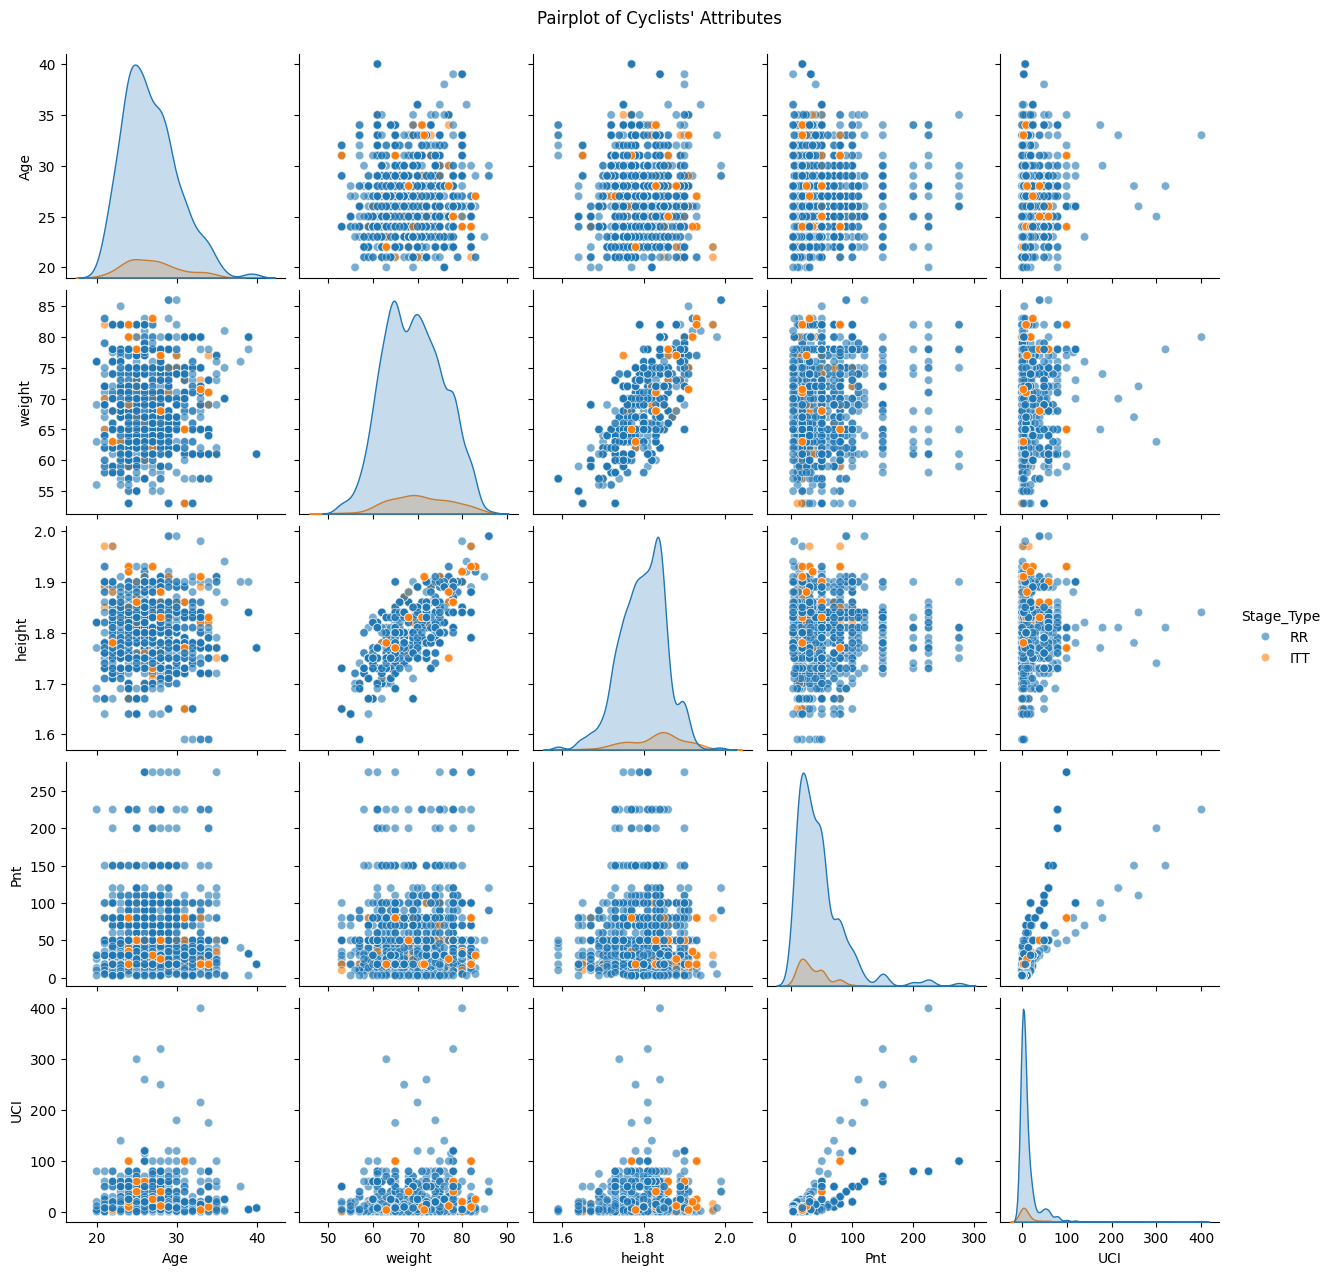

In [18]:
relevant_columns = ['Age', 'weight', 'height', 'Pnt', 'UCI', 'Stage_Type']
df_clean = df[relevant_columns].dropna()
# Create pairplot to visualize relationships between numeric columns
sns.pairplot(df_clean[relevant_columns], kind='scatter', plot_kws={'alpha': 0.6}, hue='Stage_Type')
plt.suptitle("Pairplot of Cyclists' Attributes", y=1.02)
plt.show()

<Axes: >

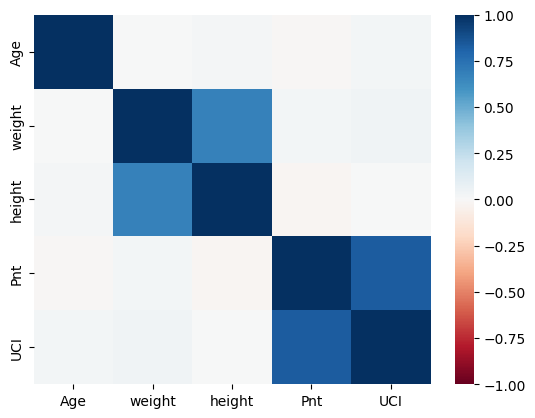

In [10]:
# Unless data gets cleaned/formatted (which we will be doing later), only numerical data can be used

relevant_columns = ['Age', 'weight', 'height', 'Pnt', 'UCI']
df_clean = df[relevant_columns].dropna()

corr = df_clean.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap="RdBu")

### 4. Quality of the Data

The quality of the data will be identified by the following characteristics:
- Completeness: this will indicated if the database is missing any entries. This can be achieved by finding null values. Missing data may also be annotated in a different manner; for example with '-' or '0'.
- Consistency: this will indicate if the formatting of the data is uniform or not. Think of time/day formats, which can variate among eachother. Identifying consistency in data will result in more accurate results.
- Accuracy: this will indicate if data entries are true to their real values. This is also important to get an accurate representation of the true values.

In [11]:
# Count the amount of null values
print(df.isnull().sum())

id                   0
Rnk                  0
GC               30420
Timelag          30420
BiB                  0
Rider                0
Age                  0
Team                29
UCI             214074
Pnt             194158
Time                 0
Circuit              0
Race_Name            0
Stage_Name       25241
Date                 0
Stage_Type           0
Start                0
Finish               0
Race_ID              0
Stage_Number         0
Length               0
Category             0
Race_url             0
Stage_url        25241
fullname         52189
team             52189
birthdate        52189
country          52189
height           52189
weight           52189
rider_url        52189
pps              52189
rdr              52189
dtype: int64


The output above shows that there are many missing entries for the following (relevant) variables:
- GC (General Classification)
- Timelag
- UCI Ranking
- Points

These missing entries can, for example, be dropped, substituted, imputated, etc.

In [12]:
inaccurate = df[df['id'] == 13323]
accurate = df[df['id'] == 216]

print("Here's an example of an inaccurate entry for 'length':\n")
print(inaccurate[['Rnk', 'Rider', 'Length']], "\n\n")
print("Here's an example of an accurate entry for 'length':\n")
print(accurate[['Rnk', 'Rider', 'Length']])

Here's an example of an inaccurate entry for 'length':

                                 Rnk             Rider Length
rider_id                                                     
d90a16e206fa19b3fb8538d70c47ae7d   3  MONTAGUTI Matteo   0 km 


Here's an example of an accurate entry for 'length':

                                 Rnk                 Rider  Length
rider_id                                                          
21822df03823c86a6a14ceb7673b6e9a  83  AAEN JØRGENSEN Jonas  148 km


The output cell above shows an example of inaccurate/arbitrary entry that is present in the database.

### 5. Preparing the Data

#### 5.1 Actions to take
The following assessments can be made regarding the actions that need to be taken to clean the data:
- Some entries need to be uniformly formatted so they can be used for further analysis.
    - Time needs to be formatted to be correctly identified as an integer value
    - Dates need to be standardized to a certain format to be more usable with other data. It could even be categorized to determine the performance of riders per season.
    - Numerical values that are entered as strings, need to be converted from a string value to a float. For example, 'length' is formatted as a string like '150 km'. By stripping 'km' from this value will prepared it to be turned into a numercal value.
- Missing data needs to be handled. Columns with missing numerical values can be dealt with using mean or median imputation. Columns that are missing significant chunks of data need to be removed, or have rows with missing data removed.
- Extreme values should be removed by identifying outliers. 
- Data shoud be normalized.

#### 5.2 Formatting values
Dates and times can be converted to numerical values. Years and months can be useful for, for example, determining which season a rider has peak performance. Data like individual days and time of which an event took place are not as important, so they will be dropped. For example "12 Oktober 2016, 12:30" will be split into a column "Month: March" and "Year: 2016", the rest of the entry will be dropped.

The 'Time' entry, which represents the amount of time it took to complete a race, will also be converted into a single numerical value for simplicity. This will make it easier for analysis purposes, because it provides a more granular measure of time.

Additionally, some columns hold multiple values inside of a single variable in a text format. Specifically the 'pps' and 'rdr' columns in the 'riders' table hold important information on the total amount of points per type of a race an individual rider accumalated, and it also contains individual all-time rankings. These values will need to be split and put into separate columns for individual racers.

*Note that the 'riders' table was already combined with the 'race_results' table in our EDA.*

#### 5.3 Handling missing data
Missing data will be handled by mean imputation. For numeric variables, this is achieved by replacing missing values with the mean of the non-missing values withing that variable. This is done so that variables with large amounts of missing variables are still usable for analysis.
If it turns out that mean imputation will not result in accurate results, other options, like regression imputation, will also be explored. Regression imputation is performed for variables of which the outcome relies on other variables. For example, if weight is correlated to height, age and country, missing values for weight could be predicted by using the correlated values.

#### 5.4 Normalizing data
Normalizing data is a way of scaling different values so that they are on a similar scale or range. A standardized version of a variable can easily be achieved by dividing each variable by its standard deviation. The purpose of normalization is to give all variables equal importance in terms of variability.

#### 5.5 Identifying outliers
In the cells above, it was shown how using scatterplots was used to identify if certain values contained outliers. Boxplots can also be used to detect outliers in a visual manner.
To exclude extreme outliers from our analysis, computing Z-scores will be used. By calculating the distance between a data point and the mean, it can be determined if a data point is an outlier or not. 
the Interquartile Range method (IQR) will be used. This involves determining the first and third quartile of data, and then using these values to determine the boundaries for what will be considered an outlier. By employing outlier detection, it is ensured that the outcome of the data analysis is not skewed by extreme values.

### 6. Preparing Data for Machine Learning

The next step is preparing the data, so that machine learning can be performed over the dataset. This includes reducing the dimensions of the data, making text usable for analysis and applying reduction techniques. With a large dataset, the number of variables must be reduced for data mining algorithms to operate efficiently. Dimension reduction must be done before the data mining model is deployed.

The next five approaches can be taken to apply dimension reduction on a dataset:
1. Removing or combining categories based on the knowledge of the dataset.
2. Summarizing data to detect information overlap between variables. By doing this, redundant categories and or variables can be removed or combined.
3. Converting categorical variables into numerical variables, by using data conversion techniques.
4. Employing automated reduction techniques, such as Principal Component Analysis (PCA). By performing PCA, a new set of variables is created, which are weighted averages of the original variables. These new variables are uncorrelated and a small subset of these variables contains most of their combined information. By doing this, the dimensions of the dataset are reduced by using only a sybset of the new variables.
5. Data mining methods such as regression models, classification and regression trees can be used to determine redundant variables for removal and for combining similar categories into categorical variables.

**Why perform dimension reduction?**


In [13]:
print(df['Time'])

rider_id
659ed585810c65fe22255a5e4a9b7838    4:33:40
None                                 ,,0:00
None                                 ,,0:00
13ed0fc8c2b0dcd2c4e1ac48b88166b8     ,,0:00
c0c77a7b1a8b55d9641962ba21981cab     ,,0:00
                                     ...   
0f6a6eb1562ad250932788700507f8b1          -
bff8b2f23cc9ca12343cde90dbeb40e1          -
a941c1bf55e2b1a0f981665ca9878b88          -
43ef20e6e4e4fb9d39470962c586457f          -
331c623e3f33d0a010a7ab49c5cac0c7          -
Name: Time, Length: 225918, dtype: object


### 7. Performing Data Cleaning

The following code cells will show how the following steps in data cleaning are performed:
1. Converting month and year into separate numerical values.
2. Converting 'Time' into single numerical values. Do the same for time lag.
3. Splitting values from 'pps' and 'rdr' and putting those values into separate columns.
4. Dropping columns that are not needed for analysis
5. Applying mean imputation for missing values.
6. Identifying outliers
7. Normalizing data

##### 7.1 Converting month and year into separate numerical values

In [14]:
# Convert the 'Date' column to DateTime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%d %B %Y')

# Remove rows where 'Date' is NaT
df = df.dropna(subset=['Date'])

# Normalize 'Date' to strip out time if it's present (this keeps just the date part)
df['Date'] = df['Date'].dt.normalize()

# Extract the month and year from the column and put them in their own columns
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

print(df.info(), "\n")

print("Unique values for 'months': ", df['Month'].unique(), "\n")
print("Unique values for 'years': ",df['Year'].unique())



<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            80174 non-null  int64         
 1   Rnk           80174 non-null  object        
 2   GC            70115 non-null  float64       
 3   Timelag       70115 non-null  object        
 4   BiB           80174 non-null  object        
 5   Rider         80174 non-null  object        
 6   Age           80174 non-null  int64         
 7   Team          80148 non-null  object        
 8   UCI           2647 non-null   float64       
 9   Pnt           10407 non-null  float64       
 10  Time          80174 non-null  object        
 11  Circuit       80174 non-null  int64         
 12  Race_Name     80174 non-null  object        
 13  Stage_Name    72264 non-null  object        
 14  Date          80174 non-null  dat

##### 7.2.1 Converting 'Time' into single numerical values.

In the code cell below, we will convert the 'Time' column to time in seconds. If the time in seconds is equal to 0, it will use numpy to return NaN as a value.

In [15]:
def time_to_seconds(time_str):
    # Remove commas and any spaces
    time_str = time_str.replace(',', '').strip()

    # Check the consistency of the time format using regular expressions
    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', time_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        total_seconds = hours * 3600 + minutes * 60 + seconds  # Convert to seconds
        if total_seconds == 0:
            return np.nan  # Return NaN for 0.0 seconds
        return total_seconds

    # Do the same as the loop above, but now for MM:SS format.
    match = re.match(r'(\d{1,2}):(\d{2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan  
        return total_seconds

    # Do the same but for 0:00, 0:01, etc.
    match = re.match(r'(\d{1,2}):(\d{1,2})', time_str)  # for formats like 0:01
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan 
        return total_seconds
    
    # If format doesn't match, return NaN
    return np.nan

# Apply the conversion function to the 'Time' column
df['Time_seconds'] = df['Time'].apply(time_to_seconds)

print(df[['Time', 'Time_seconds']].head(10))
df.info()


                                     Time  Time_seconds
rider_id                                               
659ed585810c65fe22255a5e4a9b7838  4:33:40       16420.0
None                               ,,0:00           NaN
None                               ,,0:00           NaN
13ed0fc8c2b0dcd2c4e1ac48b88166b8   ,,0:00           NaN
c0c77a7b1a8b55d9641962ba21981cab   ,,0:00           NaN
None                               ,,0:00           NaN
None                               ,,0:00           NaN
None                               ,,0:00           NaN
3576983e78c8ce9f7bb83dd81fc09188   ,,0:00           NaN
be0ba0935b25fedd9ae6c2d69eb8a2fa   ,,0:00           NaN
<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            80174 non-null  int64         
 1   Rnk        

##### 7.2.2 Converting 'Timelag' into single numerical values.

Now let's do the same for timelag, where we convert the timelag values to seconds

In [16]:
def timelag_to_seconds(timelag_str):
    # Check if the timelag_str contains missing values
    if pd.isna(timelag_str):
        return np.nan

    # Remove the '+' sign
    timelag_str = timelag_str.lstrip('+').strip()

    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', timelag_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        return hours * 3600 + minutes * 60 + seconds

    # Check for MM:SS format (without hours)
    match = re.match(r'(\d{1,2}):(\d{2})', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds
    
    match = re.match(r'(\d+):(\d+)', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds

    return np.nan

df['Timelag_seconds'] = df['Timelag'].apply(timelag_to_seconds)

df['Timelag_seconds'] = df['Timelag_seconds'].replace(0.0, np.nan)

print(df[['Timelag', 'Timelag_seconds']].head(10))
df.info()


                                 Timelag  Timelag_seconds
rider_id                                                 
659ed585810c65fe22255a5e4a9b7838   +0:00              NaN
None                               +0:04              4.0
None                               +0:06              6.0
13ed0fc8c2b0dcd2c4e1ac48b88166b8   +0:10             10.0
c0c77a7b1a8b55d9641962ba21981cab   +0:10             10.0
None                               +0:10             10.0
None                               +0:10             10.0
None                               +0:10             10.0
3576983e78c8ce9f7bb83dd81fc09188   +0:10             10.0
be0ba0935b25fedd9ae6c2d69eb8a2fa   +0:10             10.0
<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               80174 non-null

##### 7.2.3 Converting 'Distance' into a single numerical value
To turn distance (like '129.0' km') from a string into a float, we will replace 'km

In [17]:
df['Length'] = df['Length'].str.replace(' km', '', regex=False)

# Convert to numeric and replace 0 with NaN
df['Length'] = pd.to_numeric(df['Length'], errors='coerce')  # Convert to numeric and handle errors

# Replace 0 values with NaN
df['Length'] = df['Length'].replace(0.0, np.nan)

print(df['Length'])

rider_id
659ed585810c65fe22255a5e4a9b7838    149.0
None                                149.0
None                                149.0
13ed0fc8c2b0dcd2c4e1ac48b88166b8    149.0
c0c77a7b1a8b55d9641962ba21981cab    149.0
                                    ...  
61bcf7ce30dde81b7d72b17c0bc7f1db      NaN
None                                  NaN
9a7bf6664948202cbf3314e83be88008      NaN
4b87799c66182b2c474e5b28c31b68cd      NaN
0292146b9196ec7a98903cb50dae48cd      NaN
Name: Length, Length: 80174, dtype: float64


##### 7.3.1 Splitting values from 'rdr' and putting those values into separate columns.


In [19]:
# Function to convert the 'rdr' string to separate ranking columns
def extract_rankings(rdr_str):
    try:
        # Converting str to dict
        rankings = ast.literal_eval(rdr_str)
        
        # Extracting ranks, while also handling missing keys
        pcs_rnk = rankings.get('PCS Ranking', np.nan)
        uci_rnk = rankings.get('UCI World Ranking', np.nan)
        alltime_rnk = rankings.get('Specials | All Time Ranking', np.nan)
        
        return pd.Series([pcs_rnk, uci_rnk, alltime_rnk])
    except:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply the function to the 'rdr' column
df[['PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']] = df['rdr'].apply(extract_rankings)

print(df[['fullname', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']])


                                         fullname PCS_Rnk UCI_Rnk AllTime_Rnk
rider_id                                                                     
659ed585810c65fe22255a5e4a9b7838    GREIPEL André     133     289          32
None                                          NaN     NaN     NaN         NaN
None                                          NaN     NaN     NaN         NaN
13ed0fc8c2b0dcd2c4e1ac48b88166b8   SABATINI Fabio     707     NaN         NaN
c0c77a7b1a8b55d9641962ba21981cab  BENNATI Daniele     NaN     NaN         158
...                                           ...     ...     ...         ...
61bcf7ce30dde81b7d72b17c0bc7f1db  GIDICH Yevgeniy     906     615         NaN
None                                          NaN     NaN     NaN         NaN
9a7bf6664948202cbf3314e83be88008       BAŠKA Erik    1705     939         NaN
4b87799c66182b2c474e5b28c31b68cd       OSS Daniel     516    1629        1514
0292146b9196ec7a98903cb50dae48cd    WALSCHEID Max     119     12

##### 7.3.2 Splitting values from 'pps' and putting those values into separate columns.


In [20]:
def extract_points(pps_str):
    try:
        points = ast.literal_eval(pps_str)
        
        day_pnt = np.nan if points.get('One day races', '0') == '0' else points.get('One day races', np.nan)
        gc_pnt = np.nan if points.get('GC', '0') == '0' else points.get('GC', np.nan)
        tt_pnt = np.nan if points.get('Time trial', '0') == '0' else points.get('Time trial', np.nan)
        sprint_pnt = np.nan if points.get('Sprint', '0') == '0' else points.get('Sprint', np.nan)
        climb_pnt = np.nan if points.get('Climber', '0') == '0' else points.get('Climber', np.nan)
        
        return pd.Series([day_pnt, gc_pnt, tt_pnt, sprint_pnt, climb_pnt])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])

df[['Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']] = df['pps'].apply(extract_points)

print(df[['fullname', 'Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']])

                                         fullname Day_Pnt GC_Pnt TT_Pnt  \
rider_id                                                                  
659ed585810c65fe22255a5e4a9b7838    GREIPEL André    4650   1921    530   
None                                          NaN     NaN    NaN    NaN   
None                                          NaN     NaN    NaN    NaN   
13ed0fc8c2b0dcd2c4e1ac48b88166b8   SABATINI Fabio     490    568     85   
c0c77a7b1a8b55d9641962ba21981cab  BENNATI Daniele    3119   1088   1095   
...                                           ...     ...    ...    ...   
61bcf7ce30dde81b7d72b17c0bc7f1db  GIDICH Yevgeniy     222    469     20   
None                                          NaN     NaN    NaN    NaN   
9a7bf6664948202cbf3314e83be88008       BAŠKA Erik     420     52     46   
4b87799c66182b2c474e5b28c31b68cd       OSS Daniel    1217    660    417   
0292146b9196ec7a98903cb50dae48cd    WALSCHEID Max     759    207    686   

                        

##### 7.4 Dropping columns that are not needed for analysis
Since some columns were split up into other columns, their original variants are not needed anymore:
- Time
- Timelag
- Rdr
- Pps

Some columns are also not going to be used for analysis. This includes the following columns:
- Birthdate (since 'Age' is already included as a variable)
- Rider_url
- Race_url
- Stage_url

During analysis, it seemed that the following columns still contained null values that were denoted in numerical values, so let's get rid of those.
- BiB
- Race_ID


In [22]:
df.drop(['Time', 'Timelag', 'rdr', 'pps', 'birthdate', 'rider_url', 'Race_url', 'Stage_url'], axis=1, inplace=True)

# Replace all remaining zero values with NaN
df = df.replace(0, np.nan)

KeyError: "['Time', 'Timelag', 'rdr', 'pps', 'birthdate', 'rider_url', 'Race_url', 'Stage_url'] not found in axis"